# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr


# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree






# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_full_actions import choice_kernel_agent,rw_agent,rw_ck_agent
from agents_full_actions import random_agent
from simulate.hmm_weights import basic_latent_model # For the active inference model


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NTRIALS = 10
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 50
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)


# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9
    },
    "distance" : {
        "N_actions" : 4
    },
    "position" : {
        "N_actions" : 9
    }
}

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
10


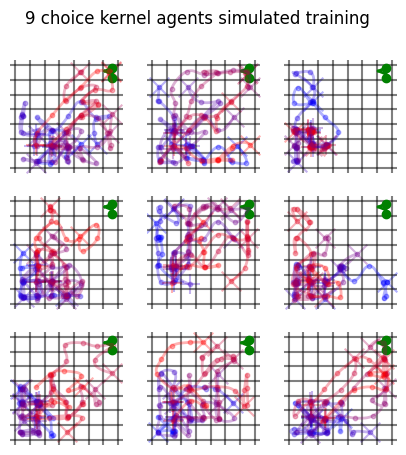

In [3]:
NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 choice kernel agents simulated training")

rw_ck_agent_hyperparameters ={
    "angle":{
        "alpha":0.1,
        "beta" :10.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
    },
    "position":{
        "alpha":0.1,
        "beta" :10.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 5.0,
    },
    "distance":{
        "alpha":0.1,
        "beta" :40.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 5.0,
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,rw_ck_agent(rw_ck_agent_hyperparameters,models_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

print(len(training_hist["actions"]))

Generate some synthetic data for the model we're interested in :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
GT LL : 
{'angle': Array(-56.499184, dtype=float32), 'distance': Array(-129.72244, dtype=float32), 'position': Array(-153.63615, dtype=float32)}


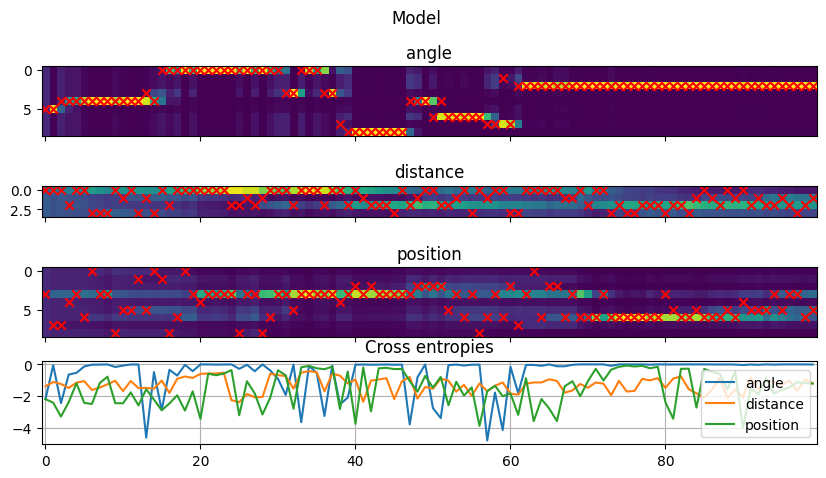

In [15]:

GT_rw_agent_hyperparameters = {
    "angle":{
        "alpha":0.5,
        "beta" :25.0,
        "alpha_ck" : 0.3,
        "beta_ck" : 5.0,
    },
    "position":{
        "alpha":0.1,
        "beta" :40.0,
        "alpha_ck" : 0.05,
        "beta_ck" :1.0,
    },
    "distance":{
        "alpha":0.1,
        "beta" :10.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
    }
}

SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,rw_ck_agent(GT_rw_agent_hyperparameters,models_constants),
                                         n_trials=10,seed = 1,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,rw_ck_agent(GT_rw_agent_hyperparameters,models_constants),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,rw_ck_agent(GT_rw_agent_hyperparameters,models_constants))
# print(predicted_actions)
model_states,other_data = state_history
qt_history,last_action_history,action_hist = model_states


# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(10,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)

[[[-2.19722462e+00 -1.04567587e-01 -2.20694470e+00 ... -6.56812936e-02
   -1.01076448e-02 -3.92512739e-01]
  [-2.30588689e-01 -1.72475651e-02 -1.39142619e-02 ... -2.20618200e+00
   -2.66819209e-01 -1.90608346e+00]
  [-6.79741614e-03 -1.35414181e-02 -4.19296026e-02 ... -7.04867542e-01
   -2.23959723e-04 -2.87848741e-01]
  ...
  [-8.34499879e-05 -9.53674771e-07 -3.62581195e-04 ... -1.40796081e-04
   -4.87734238e-03 -3.25613568e-04]
  [-1.05144200e-03 -1.20688754e-03 -6.00832864e-05 ... -2.88587704e-04
   -1.09678564e-04 -4.94244625e-04]
  [-2.15786882e-03 -4.54111665e-04 -1.40246702e-03 ... -3.69549480e-06
   -1.19209999e-05 -5.62683672e-05]]

 [[-2.19722462e+00 -1.05193064e-01 -2.19238949e+00 ... -1.09434925e-01
   -1.56014711e-02 -6.12328172e-01]
  [-4.88158107e-01 -4.61370796e-02 -3.69584151e-02 ... -2.05875492e+00
   -2.66875356e-01 -2.10382915e+00]
  [-8.72551277e-03 -1.42310178e-02 -4.56446521e-02 ... -1.53950894e+00
   -8.21749156e-04 -8.34084272e-01]
  ...
  [-2.79286760e-04 -1.9

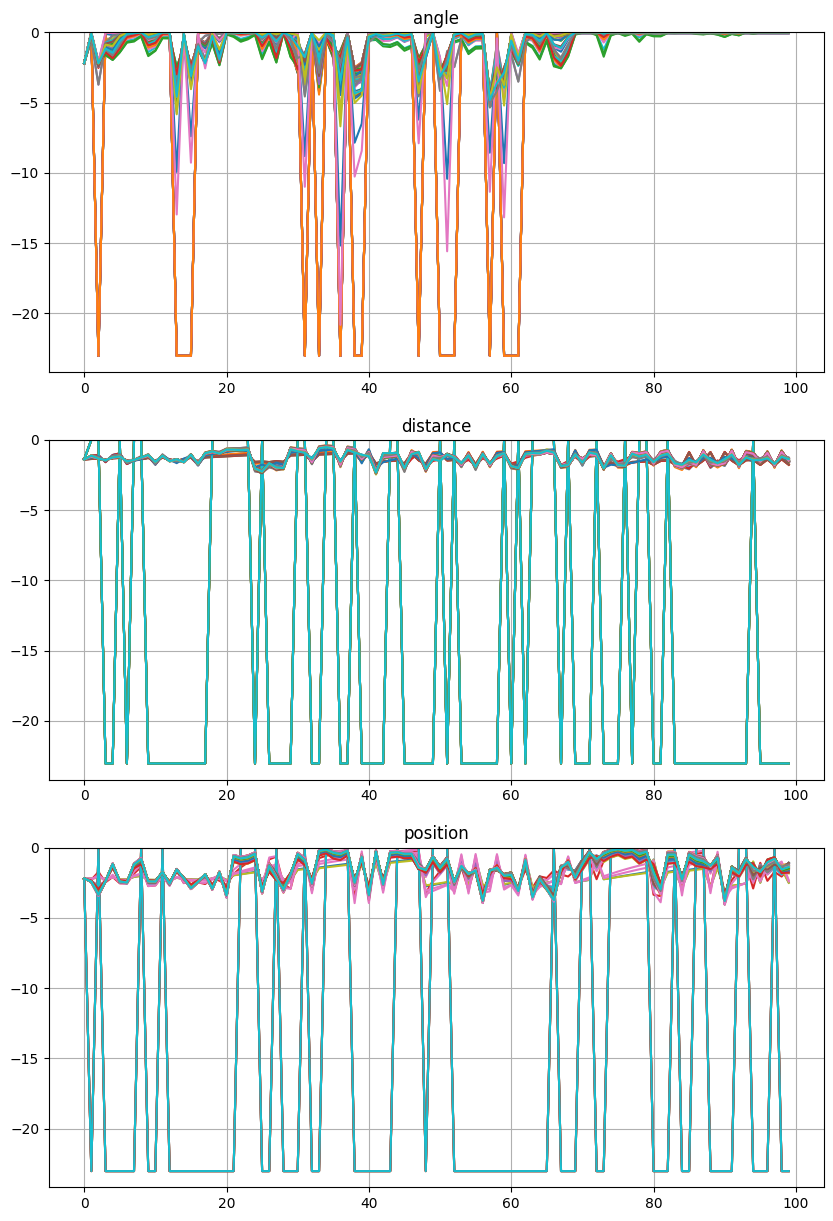

In [18]:


# Assuming uniform distributions for all parameters :
feature_range_tree ={
    "angle":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50]),
    },
    "position":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50])
    },
    "distance":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50])
    }
}
static_agent = partial(rw_ck_agent,constants= models_constants)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            static_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=100,num_steps=250)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum"))(all_fin_params)

print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()